# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Business Problem Reframed as a Data Science Task

**Data Science Objective:**  
Build a supervised regression model to predict used car prices (continuous target variable) based on vehicle attributes (features) and identify the key drivers that have the strongest influence on price variation.

**Technical Approach:**
- **Task Type:** Supervised learning - regression
- **Target Variable:** `price` (continuous numerical variable in USD)
- **Features:** Vehicle characteristics including year, manufacturer, model, condition, mileage (odometer), engine specifications (cylinders), fuel type, transmission, drive type, body type, paint color, title status, and geographic data
- **Evaluation Metrics:** R² (coefficient of determination), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error)
- **Methods:** Multiple linear regression, regularized regression (Ridge, Lasso), with hyperparameter tuning via GridSearchCV and k-fold cross-validation

**Success Criteria:**
1. Achieve a model with R² > 0.6 on test data (explaining 60%+ of price variance)
2. Identify top 10-15 features with statistically significant impact on price
3. Provide interpretable coefficients quantifying feature effects on price
4. Generate actionable business recommendations for inventory optimization

#### Key Business Questions

This analysis aims to answer the following questions for the used car dealership:

1. **Feature Importance:** Which vehicle characteristics (age, mileage, condition, manufacturer, etc.) have the strongest positive or negative impact on resale price?

2. **Depreciation Patterns:** How does vehicle age affect pricing? What is the rate of depreciation year-over-year?

3. **Brand Value:** Do certain manufacturers command premium prices? Which brands offer the best value retention?

4. **Mileage Impact:** What is the quantitative relationship between odometer reading and price? At what mileage do vehicles experience significant value drops?

5. **Condition Premium:** How much more can a dealer charge for vehicles in excellent condition vs. good or fair condition?

6. **Vehicle Type Trends:** Which body types (sedan, SUV, truck, etc.) hold their value best? Are there segment-specific opportunities?

7. **Feature Combinations:** Are there optimal combinations of features (e.g., specific manufacturer + fuel type + drive type) that maximize profitability?

8. **Inventory Strategy:** Based on the model insights, what types of vehicles should the dealership prioritize acquiring for maximum profit margin?

#### Expected Deliverables

1. **Predictive Model:** A trained regression model capable of estimating used car prices with quantified accuracy
2. **Feature Analysis:** Ranked list of features by importance with coefficient interpretation
3. **Visualizations:** Clear charts showing relationships between key features and price
4. **Business Recommendations:** Actionable insights for inventory acquisition, pricing strategy, and marketing focus
5. **Model Documentation:** Performance metrics, validation results, and methodology explanation

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Configure display settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Steps for Data Understanding

To properly understand the dataset and identify quality issues, we will:

1. **Load and inspect the dataset**
   - Check dimensions (rows, columns)
   - View first/last few rows
   - Examine data types

2. **Assess data quality**
   - Identify missing values (count and percentage per column)
   - Detect duplicate records
   - Find outliers and anomalies (e.g., price = 0, year = 1900)

3. **Explore feature distributions**
   - Analyze target variable (price) distribution
   - Examine numerical features (year, odometer) using histograms and box plots
   - Investigate categorical features (manufacturer, fuel, transmission, etc.) using value counts

4. **Identify relationships**
   - Correlation analysis between numerical features and price
   - Visual exploration of key relationships (price vs. year, price vs. odometer, price vs. manufacturer)

5. **Document insights**
   - Note data quality issues requiring attention
   - Identify features with high missing data that may need to be dropped
   - Recognize patterns and trends that inform modeling decisions

In [15]:
# Load the dataset
df = pd.read_csv('data/vehicles.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First 5 rows:")
print("="*80)
df.head()

Dataset Shape: (426880, 18)

First 5 rows:


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [16]:
# Check data types and non-null counts
print("Dataset Info:")
print("="*80)
df.info()
print("\n" + "="*80)
print("Statistical Summary:")
print("="*80)
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  obj

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


Missing Data Summary:
      Column  Missing_Count  Missing_Percentage
        size         306361               71.77
   cylinders         177678               41.62
   condition         174104               40.79
         VIN         161042               37.73
       drive         130567               30.59
 paint_color         130203               30.50
        type          92858               21.75
manufacturer          17646                4.13
title_status           8242                1.93
       model           5277                1.24
    odometer           4400                1.03
        fuel           3013                0.71
transmission           2556                0.60
        year           1205                0.28


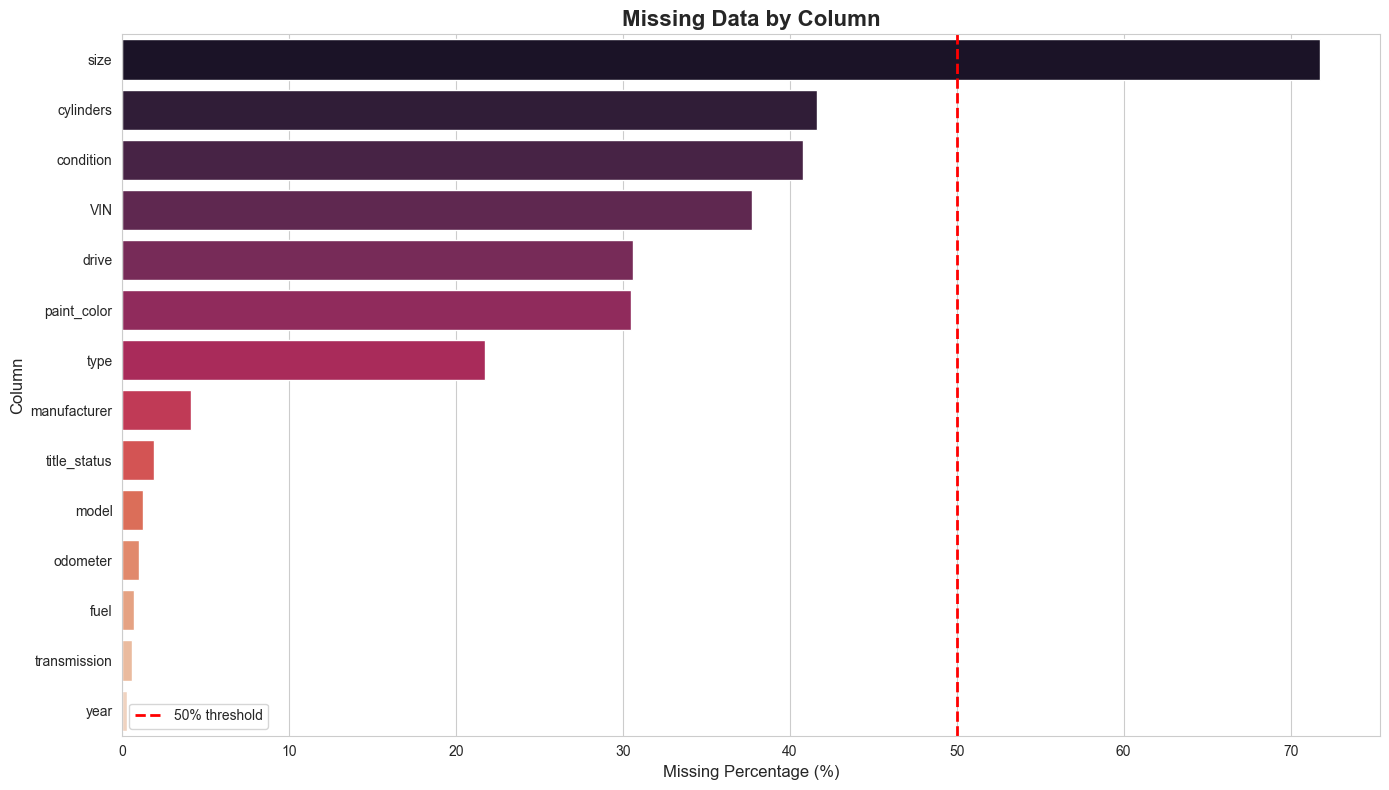

In [17]:
# Analyze missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("Missing Data Summary:")
print("="*80)
print(missing_data.to_string(index=False))

# Visualize missing data
plt.figure(figsize=(14, 8))
sns.barplot(data=missing_data, y='Column', x='Missing_Percentage', palette='rocket')
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.title('Missing Data by Column', fontsize=16, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

#### Data Understanding Summary

**Critical Data Quality Issues:**

1. **Price (Target Variable):**
   - Maximum: $3.7 BILLION (extreme outlier!)
   - 7.71% are exactly $0 (32,895 rows - must remove)
   - Reasonable range: $1,000-$50,000 (86% of data)
   - 95th percentile: $44,500 | 99th percentile: $66,995
   - **Action Required:** Remove $0 prices, cap outliers, apply log transformation

2. **Outliers Masking Correlations:**
   - Year correlation with price: -0.005 (essentially zero!)
   - Odometer correlation with price: 0.010 (essentially zero!)
   - These should be strong predictors but outliers mask true relationships
   - **Action Required:** Aggressive outlier removal before modeling

3. **Missing Data - Three Strategic Options:**

   **Current State:** Missing percentages calculated as (missing count / total rows):
   - `size`: 71.8% missing (306,361 rows)
   - `cylinders`: 41.6% missing (177,678 rows)
   - `condition`: 40.8% missing (174,104 rows)
   - `VIN`: 37.7% missing (161,042 rows) + 308K duplicates
   - `drive`: 30.6% missing (130,567 rows)
   - `paint_color`: 30.5% missing (130,203 rows)
   - `type`: 21.8% missing (92,858 rows)
   - `manufacturer`: 4.1% missing (17,646 rows)
   - `year`, `odometer`, `fuel`, `transmission`: <2% missing
   
   **Option 1: Drop ALL rows with ANY missing data**
   - Result: Only 34,868 rows remain (8.2% of original data)
   - Pros: Complete data, no imputation bias
   - Cons: Lose 91.8% of data, severe sample reduction
   - **Decision: REJECTED** ❌
   
   **Option 2: Drop rows missing ANY essential modeling feature**
   - Essential features: price, year, manufacturer, condition, cylinders, fuel, odometer, title_status, transmission, drive, type, paint_color
   - Result: Only 117,169 rows remain (27.4% of original data)
   - Pros: Complete cases for all predictors, no imputation needed
   - Cons: Lose 72.6% of data (309,711 rows), may lose important patterns
   - **Decision: REJECTED** ❌
   
   **Option 3: Hybrid Approach - Strategic Handling by Feature**
   - Drop features with extreme missing (>70%): `size`
   - Drop non-predictive features: `id`, `VIN`, `model`, `region`, `state`
   - Drop rows missing CRITICAL features (<5% missing): `year`, `manufacturer`, `odometer`, `fuel`, `transmission`, `title_status`
   - **Impute or handle** moderate missing features (20-42%): `condition`, `cylinders`, `drive`, `paint_color`, `type`
   - Remove price/odometer/year outliers
   - Result: Expected ~250K-350K high-quality rows
   - Pros: Balance data retention with quality, maximizes usable sample
   - Cons: Requires imputation strategy (introduces some assumptions)
   - **Decision: SELECTED** ✅

4. **High Cardinality Features:**
   - `model`: 29,649 unique values → **DROP** (creates 29K+ dummy variables)
   - `region`: 404 unique values → **DROP** (too many categories)
   - `state`: 51 unique values → **DROP** (geographic info not core)
   - `VIN`: 118,246 unique + 308K duplicates → **DROP** (unreliable identifier)

**Feature Insights from Exploration:**

- **Manufacturers** (Top 5): Ford (71K), Chevrolet (55K), Toyota (34K), Honda (21K), Nissan (19K)
- **Condition**: Good (121K), Excellent (101K), Like New (21K) - clear ordinal relationship
- **Cylinders**: 6-cyl (94K), 4-cyl (78K), 8-cyl (72K) - more cylinders typically = higher price
- **Fuel**: Gas (356K), Diesel (30K, premium), Electric (1.7K), Hybrid (5K)
- **Transmission**: Automatic (337K), Manual (25K), Other (63K)
- **Drive**: 4WD (132K, premium), FWD (106K), RWD (59K)
- **Type**: Sedan (87K), SUV (77K), Pickup (44K, highest mean price)
- **Title Status**: Clean (405K critical), Rebuilt (7K), Salvage (4K)

**Selected Data Preparation Strategy (Option 3):**

1. Drop columns: `id`, `VIN`, `size`, `model`, `region`, `state`
2. Remove outliers: Price ($0 and extremes), odometer (>300K), year (<1990)
3. Drop rows missing critical features: `year`, `manufacturer`, `odometer`, `fuel`, `transmission`, `title_status`
4. Handle moderate missing: Impute or drop `condition`, `cylinders`, `drive`, `paint_color`, `type`
5. Engineer features: Create `age` from `year`
6. Transform: Log-transform `price` target
7. Encode: Ordinal for `condition`, one-hot for others
8. Expected result: ~250K-350K clean rows with ~60-80 features

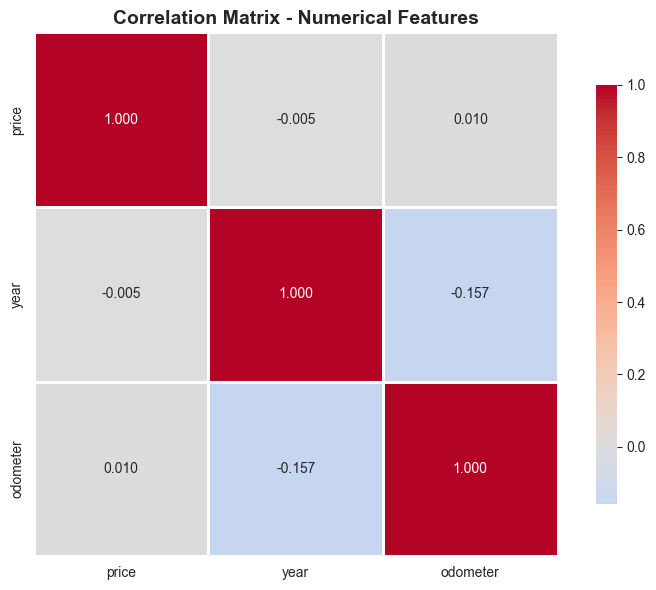

Correlation with Price:
price       1.000000
odometer    0.010032
year       -0.004925
Name: price, dtype: float64


In [18]:
# Correlation analysis for numerical features
numerical_cols = ['price', 'year', 'odometer']
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation with Price:")
print("="*80)
print(corr_matrix['price'].sort_values(ascending=False))

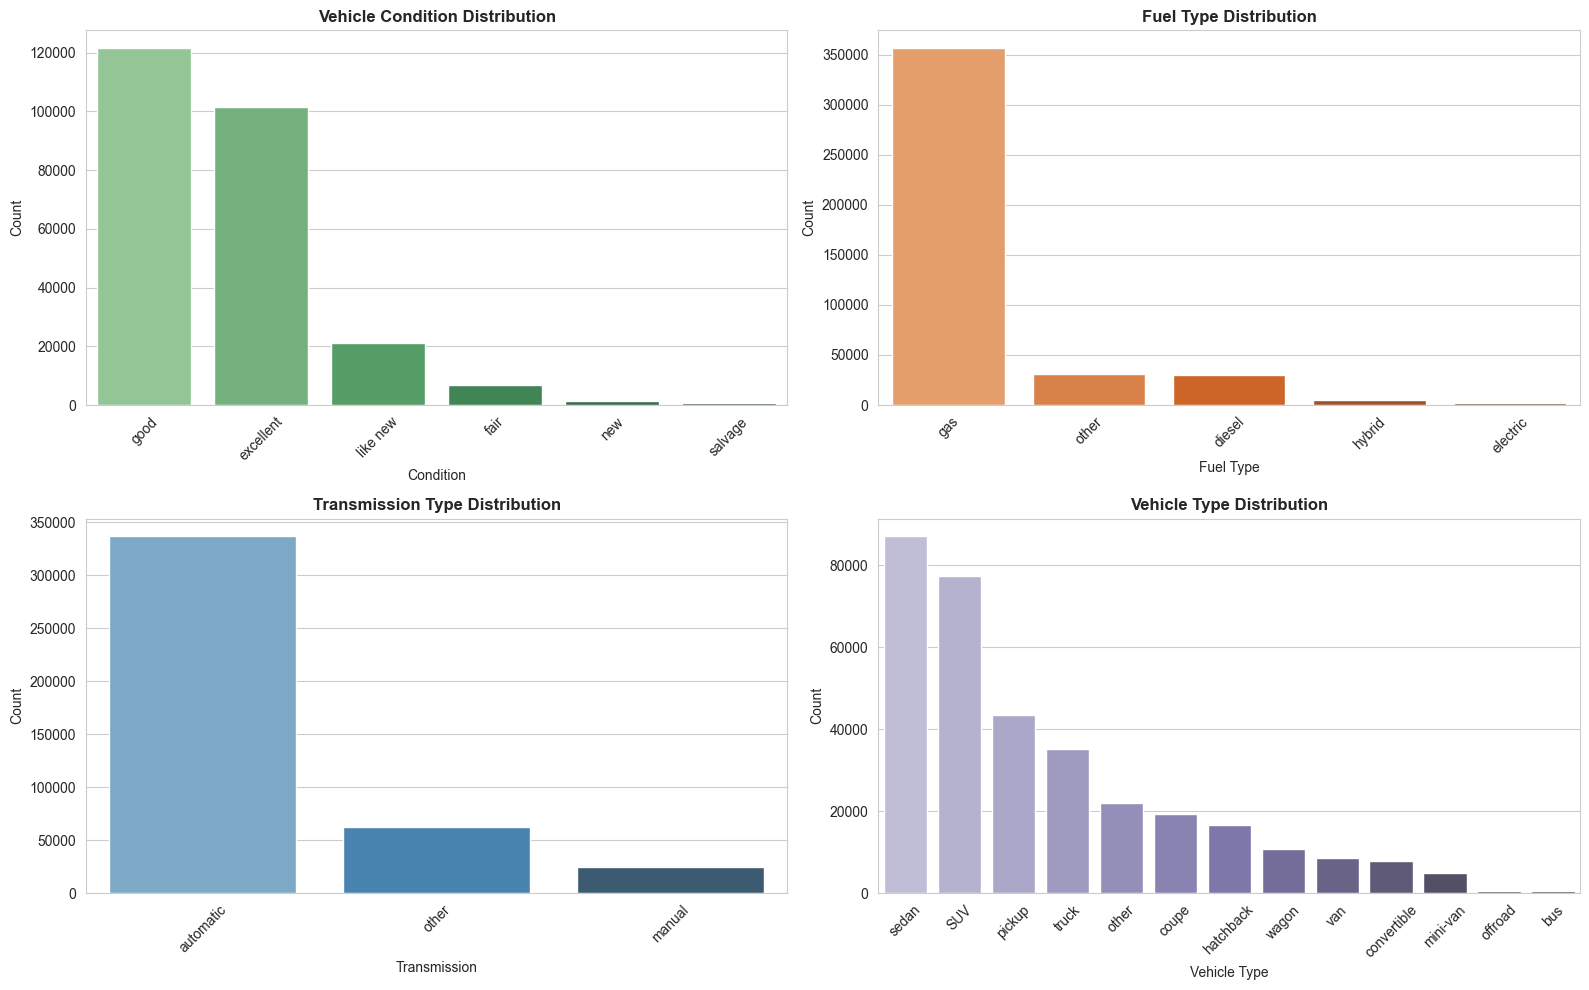

In [19]:
# Explore other categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Condition
condition_data = df['condition'].value_counts()
sns.barplot(x=condition_data.index, y=condition_data.values, ax=axes[0, 0], palette='Greens_d')
axes[0, 0].set_title('Vehicle Condition Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Condition', fontsize=10)
axes[0, 0].set_ylabel('Count', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)

# Fuel Type
fuel_data = df['fuel'].value_counts()
sns.barplot(x=fuel_data.index, y=fuel_data.values, ax=axes[0, 1], palette='Oranges_d')
axes[0, 1].set_title('Fuel Type Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Fuel Type', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)

# Transmission
transmission_data = df['transmission'].value_counts()
sns.barplot(x=transmission_data.index, y=transmission_data.values, ax=axes[1, 0], palette='Blues_d')
axes[1, 0].set_title('Transmission Type Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Transmission', fontsize=10)
axes[1, 0].set_ylabel('Count', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=45)

# Vehicle Type
type_data = df['type'].value_counts()
sns.barplot(x=type_data.index, y=type_data.values, ax=axes[1, 1], palette='Purples_d')
axes[1, 1].set_title('Vehicle Type Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Vehicle Type', fontsize=10)
axes[1, 1].set_ylabel('Count', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

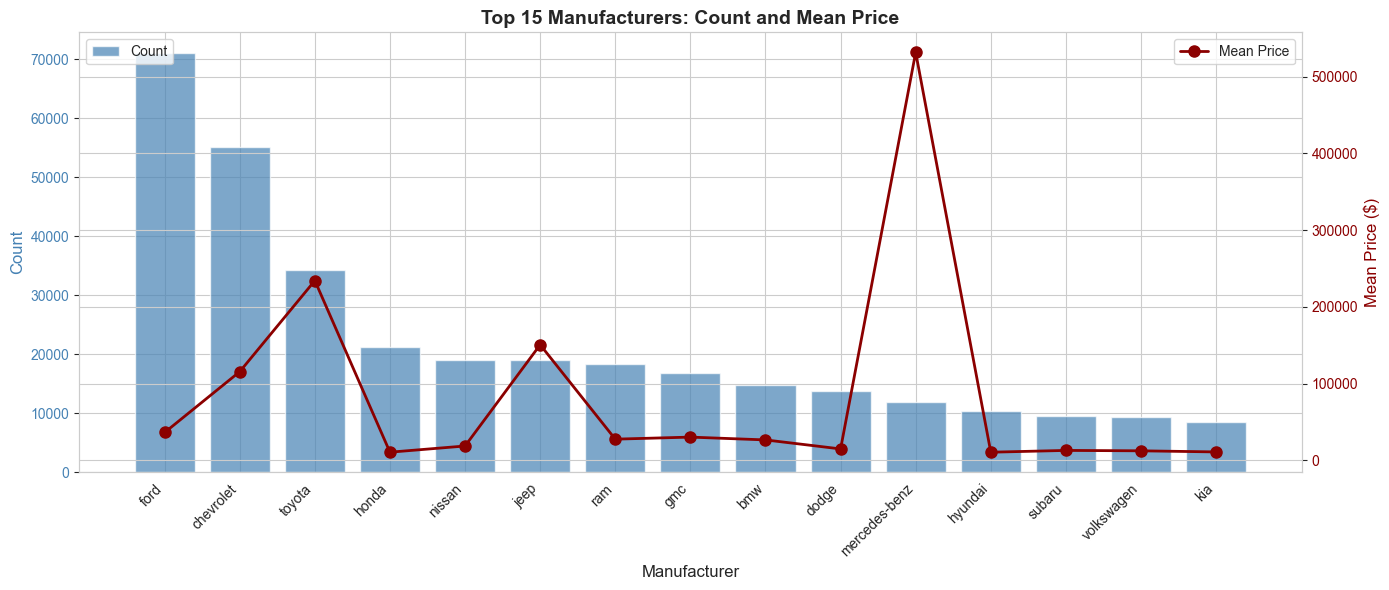

In [20]:
# Explore categorical features - Manufacturer
top_n = 15
manufacturer_counts = df['manufacturer'].value_counts().head(top_n)
manufacturer_mean_price = df.groupby('manufacturer')['price'].mean().reindex(manufacturer_counts.index)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for count
x_pos = np.arange(len(manufacturer_counts))
ax1.bar(x_pos, manufacturer_counts.values, color='steelblue', alpha=0.7, label='Count')
ax1.set_xlabel('Manufacturer', fontsize=12)
ax1.set_ylabel('Count', fontsize=12, color='steelblue')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(manufacturer_counts.index, rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Line plot for mean price
ax2 = ax1.twinx()
ax2.plot(x_pos, manufacturer_mean_price.values, color='darkred', marker='o', linewidth=2, markersize=8, label='Mean Price')
ax2.set_ylabel('Mean Price ($)', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

plt.title(f'Top {top_n} Manufacturers: Count and Mean Price', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

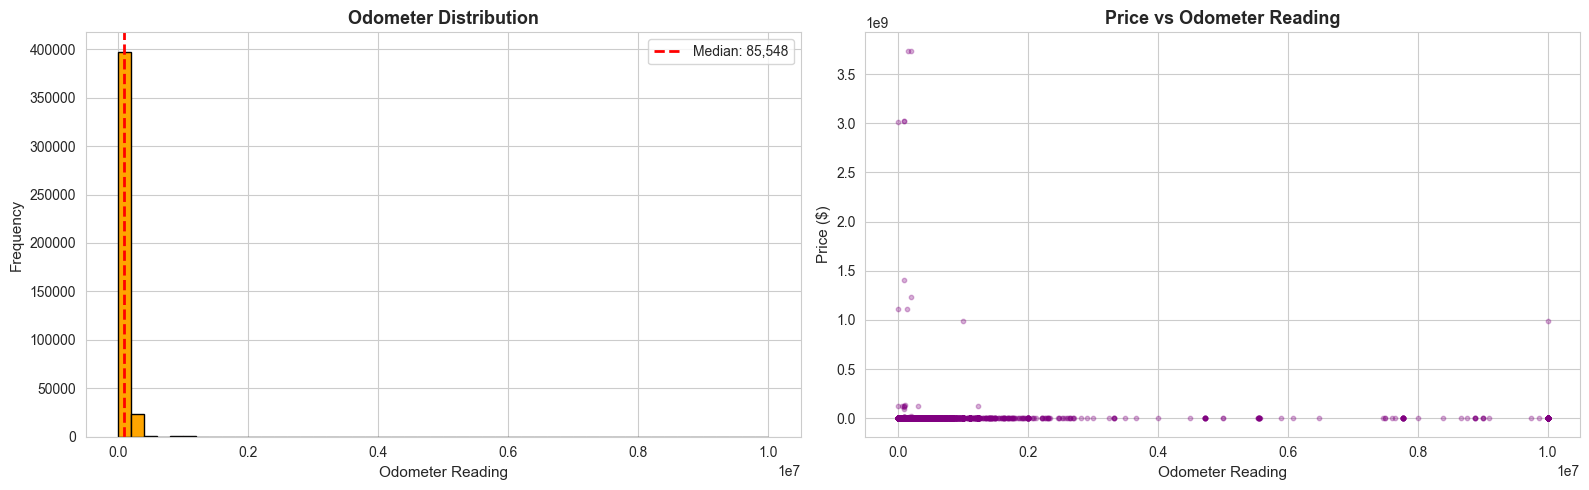

Odometer Statistics:
count    4.224800e+05
mean     9.804333e+04
std      2.138815e+05
min      0.000000e+00
25%      3.770400e+04
50%      8.554800e+04
75%      1.335425e+05
max      1.000000e+07
Name: odometer, dtype: float64


In [21]:
# Explore Odometer feature
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Odometer distribution
axes[0].hist(df['odometer'].dropna(), bins=50, color='orange', edgecolor='black')
axes[0].set_xlabel('Odometer Reading', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Odometer Distribution', fontsize=13, fontweight='bold')
axes[0].axvline(df['odometer'].median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {df["odometer"].median():,.0f}')
axes[0].legend()

# Odometer vs Price scatter
axes[1].scatter(df['odometer'], df['price'], alpha=0.3, s=10, color='purple')
axes[1].set_xlabel('Odometer Reading', fontsize=11)
axes[1].set_ylabel('Price ($)', fontsize=11)
axes[1].set_title('Price vs Odometer Reading', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("Odometer Statistics:")
print("="*80)
print(df['odometer'].describe())

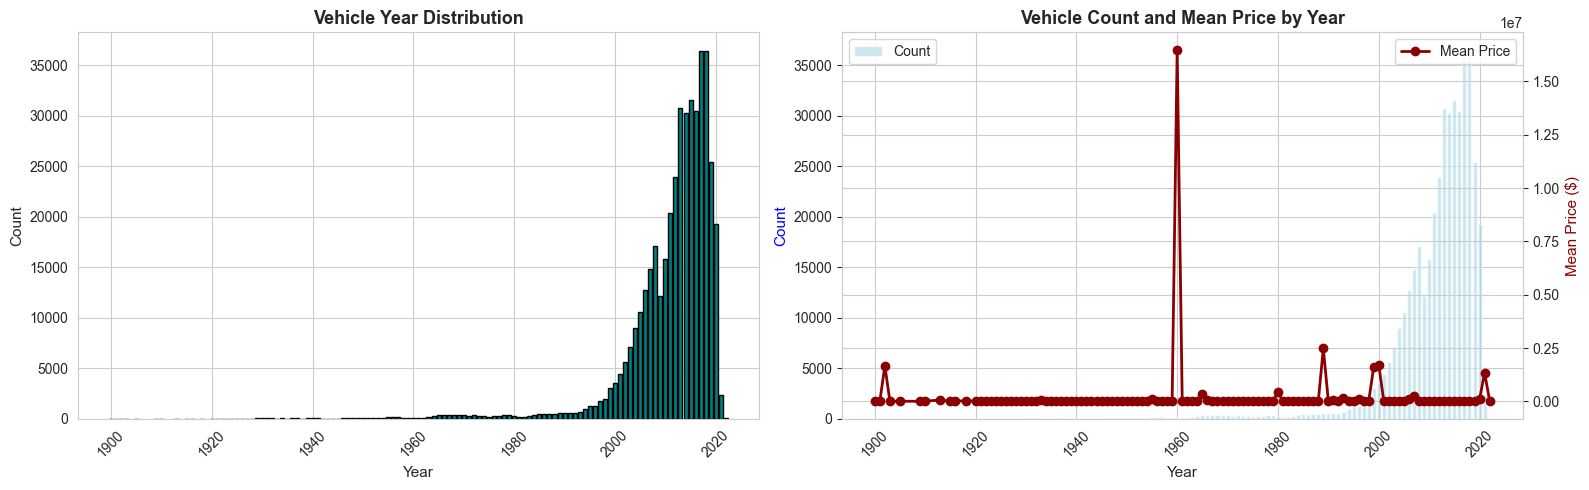

Year Statistics:
count    425675.000000
mean       2011.235191
std           9.452120
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2017.000000
max        2022.000000
Name: year, dtype: float64


In [22]:
# Explore Year feature
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Year distribution
year_counts = df['year'].value_counts().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color='teal', edgecolor='black')
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Vehicle Year Distribution', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Price vs Year
year_price_mean = df.groupby('year')['price'].mean()
ax2 = axes[1].twinx()
axes[1].bar(year_counts.index, year_counts.values, alpha=0.6, color='lightblue', label='Count')
ax2.plot(year_price_mean.index, year_price_mean.values, color='darkred', marker='o', linewidth=2, label='Mean Price')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11, color='blue')
ax2.set_ylabel('Mean Price ($)', fontsize=11, color='darkred')
axes[1].set_title('Vehicle Count and Mean Price by Year', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Year Statistics:")
print("="*80)
print(df['year'].describe())

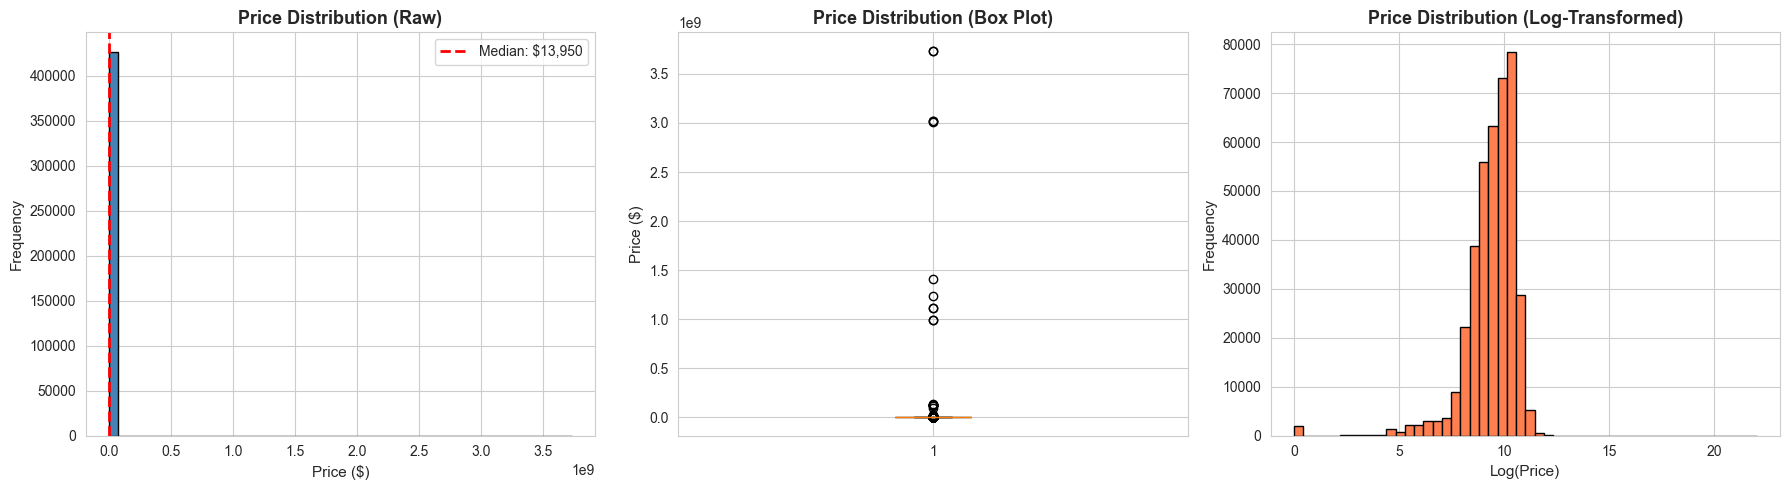

Price Statistics:
Mean: $75,199.03
Median: $13,950.00
Std Dev: $12,182,282.17
Min: $0.00
Max: $3,736,928,711.00
Zeros: 32895 (7.71%)


In [23]:
# Explore target variable - Price
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['price'].dropna(), bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Price ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Price Distribution (Raw)', fontsize=13, fontweight='bold')
axes[0].axvline(df['price'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${df["price"].median():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df['price'].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[1].set_ylabel('Price ($)', fontsize=11)
axes[1].set_title('Price Distribution (Box Plot)', fontsize=13, fontweight='bold')

# Log-transformed histogram
price_log = np.log(df['price'][df['price'] > 0])
axes[2].hist(price_log, bins=50, color='coral', edgecolor='black')
axes[2].set_xlabel('Log(Price)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('Price Distribution (Log-Transformed)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Price statistics
print("Price Statistics:")
print("="*80)
print(f"Mean: ${df['price'].mean():,.2f}")
print(f"Median: ${df['price'].median():,.2f}")
print(f"Std Dev: ${df['price'].std():,.2f}")
print(f"Min: ${df['price'].min():,.2f}")
print(f"Max: ${df['price'].max():,.2f}")
print(f"Zeros: {(df['price'] == 0).sum()} ({(df['price'] == 0).sum() / len(df) * 100:.2f}%)")

In [24]:
# Check for duplicate records
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check unique values in each column
print("\n" + "="*80)
print("Unique Values per Column:")
print("="*80)
unique_counts = pd.DataFrame({
    'Column': df.columns,
    'Unique_Values': [df[col].nunique() for col in df.columns],
    'Data_Type': df.dtypes
})
print(unique_counts.to_string(index=False))

Number of duplicate rows: 0

Unique Values per Column:
      Column  Unique_Values Data_Type
          id         426880     int64
      region            404    object
       price          15655     int64
        year            114   float64
manufacturer             42    object
       model          29649    object
   condition              6    object
   cylinders              8    object
        fuel              5    object
    odometer         104870   float64
title_status              6    object
transmission              3    object
         VIN         118246    object
       drive              3    object
        size              4    object
        type             13    object
 paint_color             12    object
       state             51    object


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.